<h1>🤖 MLAI Workshop #01</h1>

Summary of the workshop and key lessons.

💬 *Question for the audience! ...?*

<h2>🗓️ Agenda</h2>

1. ...
2. ...
3. ...


<h2>Summary</h2>

1. Functions describe the world.
2. Hypothesis space describes the function we can learn.
3. Dataset limits how we we can approximate the function.
4. Optimization decides what function we end up with

<div align="center">
    <img src="https://github.com/nextgenerationgraduatesprogram/nextgen25-mlai-workshop01/raw/main/media/notebook/NetworkSpaces.jpg" height="400"/>
    <p><em>Figure 1. Describe spaces.</em></p>
</div>

---

<h2>📈 Section 1: What's wrong with our hypothesis space?</h2>

There is some target function we want to approximate

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# target function
def f_target(x):
    return -0.68 * x + 1.4

We might observe and collect some data on this process.

Text(0, 0.5, 'y_obs')

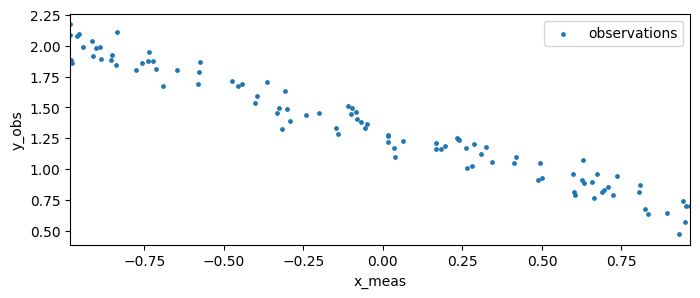

In [3]:
# observe some data using a noisy observation process
def observe_noisy(f, x):
    # we often can't sample perfectly a point in the domain perfectly
    x_noise = np.random.normal(0.05, 0.01, x.shape[0])
    x_measure = x + x_noise

    # we often can't measure the result perfectly
    y_noise = np.random.normal(-0.05, 0.09, x.shape[0])
    y_obs = f(x_measure) + y_noise

    return y_obs

# we select some points to observe the response at
x_meas = np.random.uniform(low=-1, high=1, size=100)
y_obs = observe_noisy(f_target, x_meas)

# plot the observations
fig, ax = plt.subplots(figsize=(8,3))
ax.scatter(x_meas, y_obs, s=6, label="observations")
ax.set_xlim(x_meas.min(), x_meas.max())
ax.legend(loc="best")
ax.set_xlabel("x_meas")
ax.set_ylabel("y_obs")

We might hypothesize this has a linear relationship and construct a hypothesis space to match this

In [4]:
# construct a hypothesis space
def H(a, b):
    def f(x):
        return a * x + b
    return f

We construct a loss function:

In [5]:
# define a loss function
def dataset_avg_mse_loss(f, x, y):
    # compute average mse loss between prediction `f(x)` and observation `y`
    L = np.sum((f(x) - y) ** 2) / x.shape[0]
    return L

# try a specific function
L_mse = dataset_avg_mse_loss(H(1,1), x_meas, y_obs)
L_mse

np.float64(1.2210603375271896)

We define the set of suitable candidates based on this loss function

In [6]:
# function to check if the solution is suitable
def is_suitable(L_mse, threshold):
    return L_mse < threshold

We then start from an initial set of parameters and optimize them through our loss function

Text(0.5, 0.92, 'Loss Landscape')

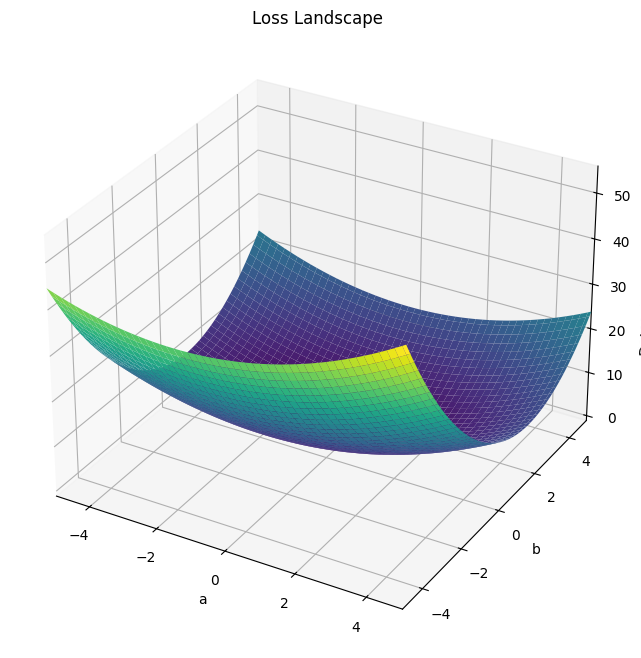

In [7]:
# visualize the loss landscape for understanding
a = np.linspace(-5, 5, num=100) # <-- explore a different range, does [-5,5] let you find the optimal solution?
b = np.linspace(-5, 5, num=100)
A, B = np.meshgrid(a, b, indexing="ij")

# lets compute the loss (error across the dataset) for each function defined by the parameter
losses = np.zeros_like(A)
for i in range(a.shape[0]):
    for j in range(b.shape[0]):
        # select a function from the hypothesis space
        f_approx = H(a=a[i], b=b[j])

        # compute loss across dataset
        losses[i,j] = dataset_avg_mse_loss(f_approx, x_meas, y_obs)

# lets plot the result
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection="3d")
s = ax.plot_surface(A, B, losses, cmap='viridis')
ax.set_xlim(a.min(), a.max())
ax.set_ylim(b.min(), b.max())
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.set_zlabel("Dataset Loss (MSE)")
ax.set_title(f"Loss Landscape")

In [8]:
# derivate of function with respect to parameters
def df_da(x, a, b):
    return x

def df_db(x, a, b):
    return 1

# derivate of loss function with respect to params : chain rule
def dL_dtheta(x, y, a, b):
    dL_da = 2 * np.mean((H(a, b)(x) - y) * df_da(x, a, b))
    dL_db = 2 * np.mean((H(a, b)(x) - y) * df_db(x, a, b))
    return (dL_da, dL_db)

In [9]:
# optimization using gradient descent
def gradient_descent(a_init, b_init, x, y, lr, steps, thresh):
    a, b = a_init, b_init
    history = []

    for idx in range(steps):
        # compute gradients
        dL_da, dL_db = dL_dtheta(x, y, a, b)

        # curr loss
        L_mse = dataset_avg_mse_loss(H(a, b), x, y)
        history.append((a, b, L_mse))

        # exit condition : found suitable solution
        if is_suitable(L_mse, thresh):
            print(f"found suitable solution (a={a:.2f}, b={b:.2f}) with loss L={L_mse:.3f} after {idx} steps")
            break

        # gradient descent update step
        a = a - lr * dL_da
        b = b - lr * dL_db

    return np.array(history)

# run gradient descent and get final parameters
trajectory = gradient_descent(a_init=.0, b_init=.0, x=x_meas, y=y_obs, lr=0.1, steps=100, thresh=0.001)
f_approx = H(trajectory[-1,0], trajectory[-1,1])

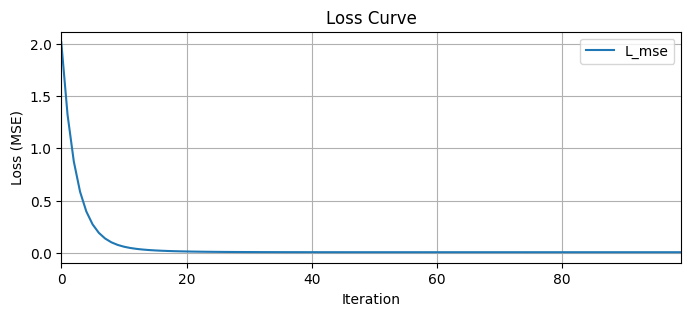

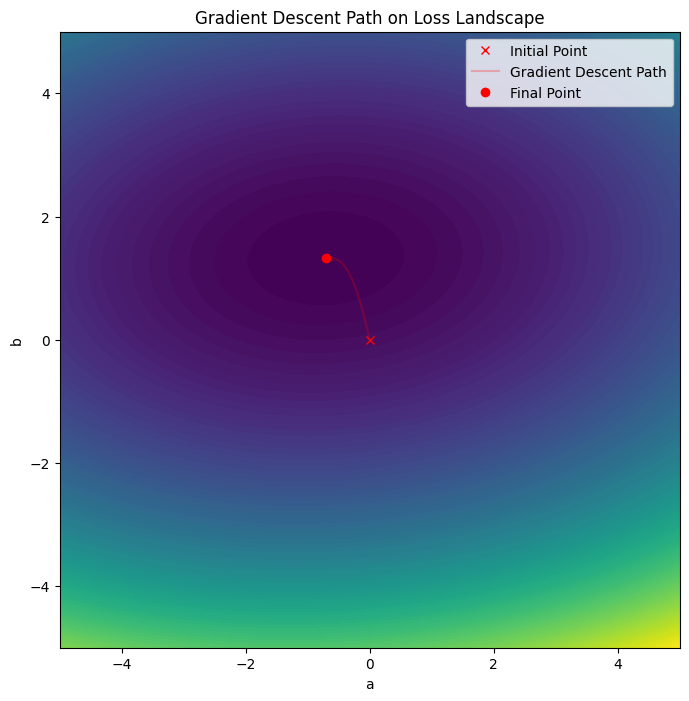

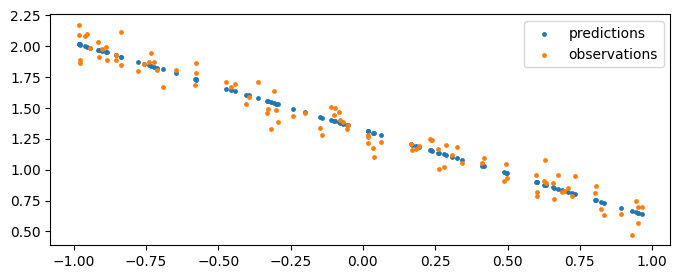

In [10]:
# Plot loss over iterations
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(trajectory[:, 2], label="L_mse")
ax.set_xlim(left=0, right=len(trajectory)-1)
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss (MSE)")
ax.set_title("Loss Curve")
ax.grid(True)
ax.legend()

# Plot the path on the loss landscape
fig, ax = plt.subplots(figsize=(8, 8))
contour = ax.contourf(A, B, losses, levels=100, cmap='viridis')
ax.set_xlim(A.min(), A.max())
ax.set_ylim(B.min(), B.max())
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.set_title("Gradient Descent Path on Loss Landscape")

# Path
ax.plot(trajectory[0, 0], trajectory[0, 1], 'rx', label="Initial Point")
ax.plot(trajectory[:, 0], trajectory[:, 1], 'r-', alpha=0.25, label="Gradient Descent Path")
ax.plot(trajectory[-1, 0], trajectory[-1, 1], 'ro', label="Final Point")
ax.legend()

# Plot predictions
fig, ax = plt.subplots(figsize=(8, 3))
ax.scatter(x_meas, f_approx(x_meas), s=6, label="predictions")
ax.scatter(x_meas, y_obs, s=6, label="observations")
ax.legend(loc="best")

We have to manually define the function for the gradients and define the optimization algorithm, instead we can use the `torch` library with its autograd engine and pre-defined optimizers to make our life much easier

In [12]:
import torch
import torch.nn as nn

class HypothesisSpace(nn.Module):
    """ implement a simple linear equation hypothesis space
    f(x) = a * x + b
    """
    def __init__(self, a: float, b: float):
        super().__init__()
        self.a = nn.Parameter(torch.tensor(a))
        self.b = nn.Parameter(torch.tensor(b))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.a * x + self.b

    def __repr__(self):
        return f"{self.a.item():.2f} x^2 + {self.b.item():.2f} x"

In [15]:
from tqdm import tqdm

# define the optimization loop aka. training loop
def training_loop(model, optimizer, loss_fn, x, y, steps, thresh = None):
    # training loop
    trajectory = []
    with tqdm(range(steps)) as pbar:
      for idx in pbar:
        # clear gradients from previous iteration
        optimizer.zero_grad()

        # performs a forwards pass : constructs the computation graph for gradients
        y_pred = model(x)

        # compute the loss function : adds more nodes to the graph
        loss = loss_fn(y, y_pred)

        # store for visualization
        trajectory.append([p.item() for p in model.parameters()] + [loss])

        # break
        if thresh is not None:
            if is_suitable(loss, thresh):
                print(f"found suitable model with loss L={loss.item():.3f} after {idx} iterations")
                break

        # performs a backwards pass : computes the gradients across the graph i.e. dL/df -> df/da -> ...
        loss.backward()

        # step optimizer : uses the gradients to perform a gradient descent step i.e. a = a - lr * dL/da
        optimizer.step()

        pbar.set_description(f"loss: {loss.item():.3f}")

    trajectory = torch.tensor(trajectory)
    return model, trajectory

In [16]:
# convert dataset to tensors
x_meas_tensor = torch.from_numpy(x_meas)
y_obs_tensor = torch.from_numpy(y_obs)

# initial model
model = HypothesisSpace(1.0, 1.0)

# define optimizer : autograd handles computing gradients etc.
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# define loss function
loss_fn = torch.nn.MSELoss()

# perform the training loop
model, trajectory = training_loop(model, optimizer, loss_fn, x_meas_tensor, y_obs_tensor, 100)

loss: 0.007: 100%|██████████| 100/100 [00:00<00:00, 470.57it/s]


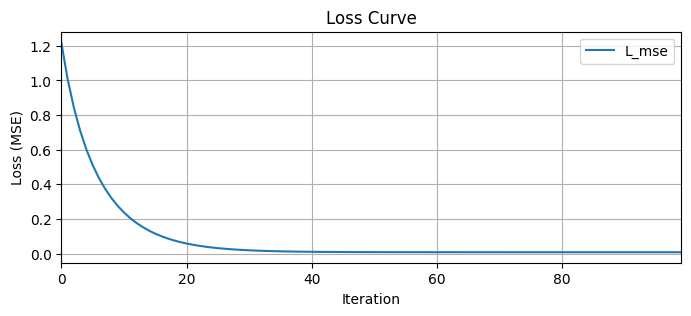

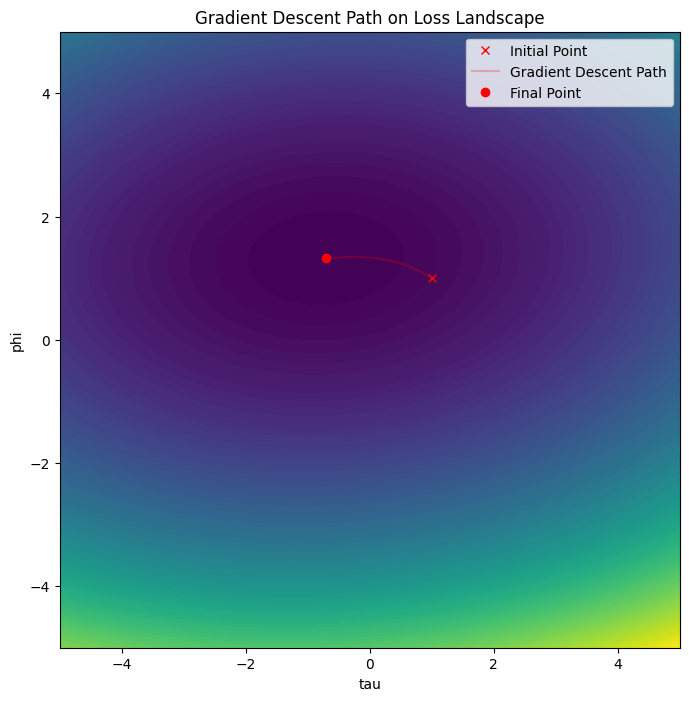

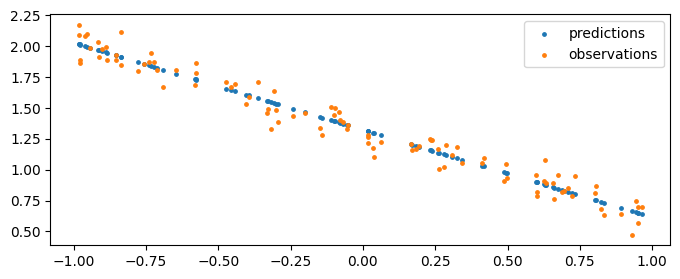

In [18]:
# Plot loss over iterations
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(trajectory[:,-1], label="L_mse")
ax.set_xlim(left=0, right=len(trajectory)-1)
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss (MSE)")
ax.set_title("Loss Curve")
ax.grid(True)
ax.legend()

# Plot the path on the loss landscape
fig, ax = plt.subplots(figsize=(8, 8))
contour = ax.contourf(A, B, losses, levels=100, cmap='viridis')
ax.set_xlim(A.min(), A.max())
ax.set_ylim(B.min(), B.max())
ax.set_xlabel("tau")
ax.set_ylabel("phi")
ax.set_title("Gradient Descent Path on Loss Landscape")

# Path
ax.plot(trajectory[0, 0], trajectory[0, 1], 'rx', label="Initial Point")
ax.plot(trajectory[:, 0], trajectory[:, 1], 'r-', alpha=0.25, label="Gradient Descent Path")
ax.plot(trajectory[-1, 0], trajectory[-1, 1], 'ro', label="Final Point")
ax.legend(loc="best")

# Plot predictions
fig, ax = plt.subplots(figsize=(8, 3))
ax.scatter(x_meas_tensor.detach(), model(x_meas_tensor).detach(), s=6, label="predictions")
ax.scatter(x_meas_tensor.detach(), y_obs_tensor, s=6, label="observations")
ax.legend(loc="best")

So with this engineering issue sorted we can return to the science.

So what happens if we have a more complicated function?

f_target = ...

Let's define the `Dataset` to wrap up `f_target_` and the observation process.

In [51]:
# define the optimization loop aka. training loop
def training_loop(model, optimizer, loss_fn, x, y, steps, thresh = None):
    losses = []
    with tqdm(range(steps)) as pbar:
      for idx in pbar:
          optimizer.zero_grad()
          loss = loss_fn(y, model(x))
          losses.append(loss)
          loss.backward()
          optimizer.step()
          pbar.set_description(f"loss: {loss.item():.3f}")
    return model, torch.tensor(losses)

In [52]:
import torch
import torch.nn as nn

class Dataset:
    def __init__(self, a: float, b: float, N = 100):
        self.__f = lambda x: 2.04 * x**3 + 1.54 * x**2 - 0.54 * x + 1.3 # f : data generating process
        self.x = torch.from_numpy(np.random.uniform(low=a, high=b, size=N)).to(dtype=torch.float32) # [N,1]
        self.y = torch.from_numpy(observe_noisy(self.__f, self.x.numpy())).to(dtype=torch.float32)
        self.x = self.x.unsqueeze(-1)
        self.y = self.y.unsqueeze(-1)
        self.x = (self.x - self.x.min()) / (self.x.max() - self.x.min())
        self.y = (self.y - self.y.min()) / (self.y.max() - self.y.min())

# define a dataset
dataset = Dataset(a=-2, b=2, N=100)

Text(0, 0.5, 'y_obs')

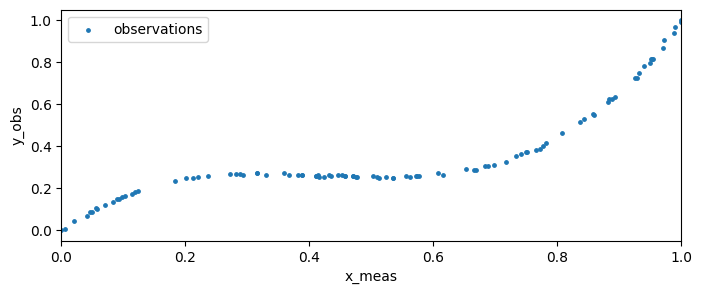

In [53]:
# plot the observations
fig, ax = plt.subplots(figsize=(8,3))
ax.scatter(dataset.x, dataset.y, s=6, label="observations")
ax.set_xlim(dataset.x.min(), dataset.x.max())
ax.legend(loc="best")
ax.set_xlabel("x_meas")
ax.set_ylabel("y_obs")

In [54]:
class HypothesisSpace(nn.Module):
    def __init__(self, a: float, b: float):
        super().__init__()
        self.a = nn.Parameter(torch.tensor([a]))
        self.b = nn.Parameter(torch.tensor([b]))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.a * x + self.b

    def __repr__(self):
        return f"{self.a.item():.2f} x^2 + {self.b.item():.2f} x + {self.c.item():.2f}"

In [55]:
def plot_loss_curve(losses):
    fig, ax = plt.subplots(figsize=(8,3))
    ax.plot(losses, label="loss")
    ax.set_xlim(left=0, right=len(losses)-1)
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss (MSE)")
    ax.set_title("Loss Curve")
    ax.grid(True, alpha=0.50)
    ax.legend()
    return fig, ax

In [56]:
def plot_predictions(model, dataset):
    fig, ax = plt.subplots(figsize=(8,3))
    with torch.no_grad():
        ax.scatter(dataset.x, model(dataset.x), s=4, label="predictions")
        ax.scatter(dataset.x, dataset.y, s=4, label="observations")
    ax.set_xlim(left=dataset.x.min(), right=dataset.x.max())
    ax.grid(True, alpha=0.50)
    ax.legend(loc="best")
    return fig, ax

loss: 0.033: 100%|██████████| 100/100 [00:00<00:00, 513.18it/s]


(<Figure size 800x300 with 1 Axes>, <Axes: >)

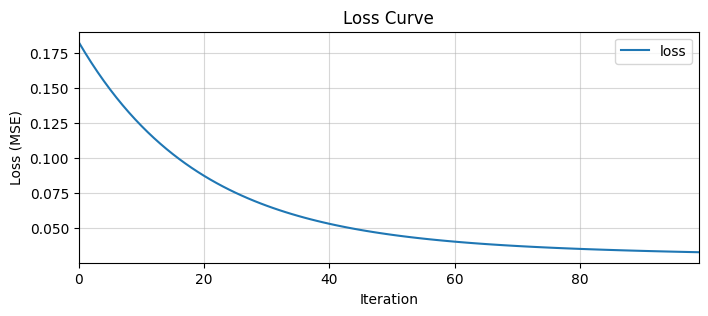

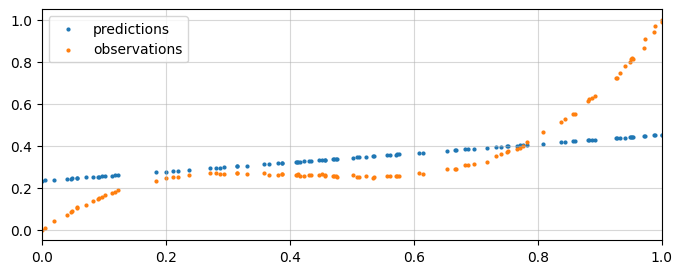

In [57]:
# initial model
model = HypothesisSpace(0.0, 0.0)

# define optimizer : autograd handles computing gradients etc.
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# perform the training loop
model, losses = training_loop(model, optimizer, loss_fn, dataset.x, dataset.y, 100, 0.1)

# plot loss curve & predictions
plot_loss_curve(losses)
plot_predictions(model, dataset)

So whats the issue here?

Our optimization process has found the minimum solution for the hypothesis class but the error is still too high for it to be a suitable solution.

Well clearly our hypothesis space is too restricted - it's unable to represent the function such that our final function is suitable - we can visualize this using spaces...

We would say our approximation error is bounded - our poor choice of model class limits our ability

So what happens when our function has an unknown form? We instead need a way to define a hypothesis class that can represent lots of different functions - this is where universal function approximations come in

Lots of different sorts of function approximators etc. fourier curves, polynomial models, etc.

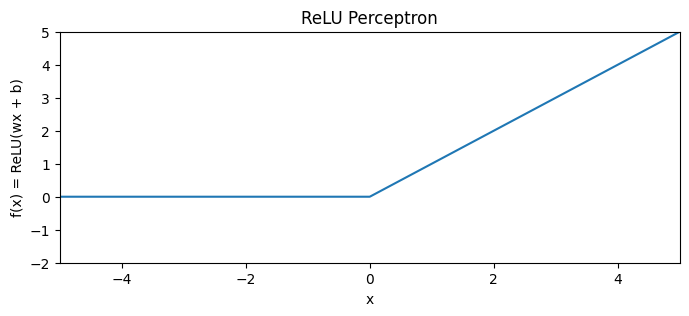

In [58]:
class Perceptron(nn.Module):
    """
    f(x) = ReLU(Wx + B)
    """
    def __init__(self, w: float, b: float):
        super().__init__()
        self.linear = nn.Linear(1, 1)
        self.linear.weight = nn.Parameter(torch.tensor([[float(w)]])) # <-- vary the parameters manually
        self.linear.bias = nn.Parameter(torch.tensor([[float(b)]]))
        self.act = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.act(self.linear(x))

with torch.no_grad():
    x = torch.linspace(-5, 5, 1000).unsqueeze(-1)
    y = Perceptron(1.0, 0.0)(x)

    # plot the perceptron function
    fig, ax = plt.subplots(figsize=(8,3))
    ax.plot(x,y)
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(-2, 5)
    ax.set_title("ReLU Perceptron")
    ax.set_xlabel("x")
    ax.set_ylabel("f(x) = ReLU(wx + b)")

Multilayer perceptrons with ReLU basis

loss: 0.013: 100%|██████████| 1000/1000 [00:01<00:00, 581.05it/s]


(<Figure size 800x300 with 1 Axes>, <Axes: >)

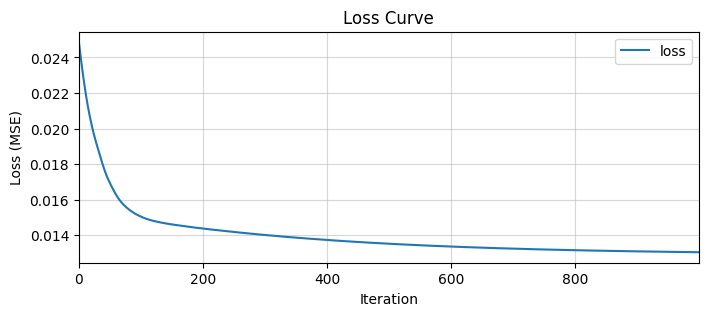

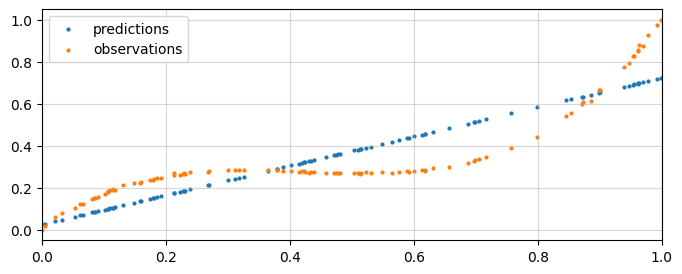

In [59]:
class Perceptron(nn.Module):
    """
    f(x) = ReLU(Wx + B)
    """
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)

        # specific initialization
        # self.linear.weight = nn.Parameter(torch.tensor([[1.0]])) # <-- define a specific starting model init
        # self.linear.bias = nn.Parameter(torch.tensor([[0.0]]))

        # random initialization
        nn.init.uniform_(self.linear.weight, -1, 1)
        nn.init.uniform_(self.linear.bias, -1, 1)

        self.act = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.act(self.linear(x))


model = Perceptron()
dataset = Dataset(a=-2, b=2, N=100)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
model, losses = training_loop(model, optimizer, loss_fn, dataset.x, dataset.y, 1000)

plot_loss_curve(losses)
plot_predictions(model, dataset)

loss: 0.002: 100%|██████████| 2000/2000 [00:09<00:00, 208.89it/s]


(<Figure size 800x300 with 1 Axes>, <Axes: >)

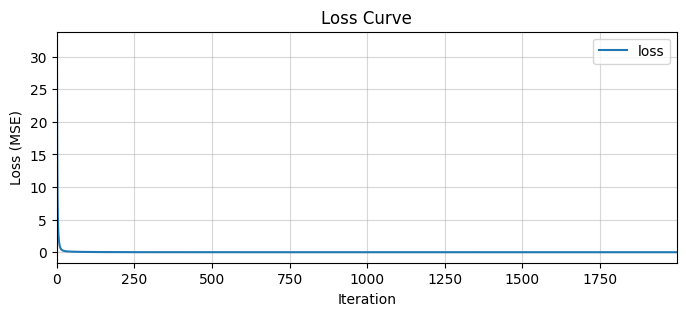

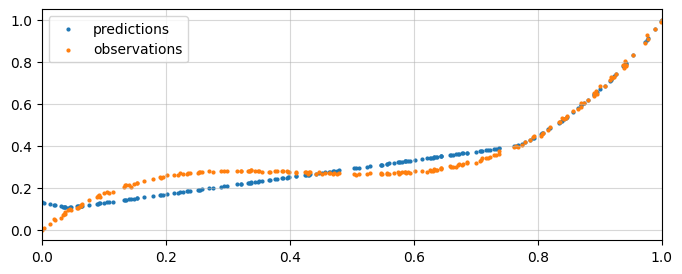

In [60]:
class PerceptronLayer(nn.Module):
    def __init__(self, N: int = 1):
        super().__init__()
        self.perceptrons = nn.ModuleList([Perceptron() for _ in range(N)])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # y_pred = Perceptron0(x) + ... + PerceptronN(x)
        y_pred = 0
        for perceptron in self.perceptrons:
            y_pred = y_pred + perceptron(x)
        return y_pred

model = PerceptronLayer(N=20)
dataset = Dataset(a=-2, b=2, N=200)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
model, losses = training_loop(model, optimizer, loss_fn, dataset.x, dataset.y, 2000)

plot_loss_curve(losses)
plot_predictions(model, dataset)

Without different initialization the model likely collapses

In [61]:
for perceptron in model.perceptrons:
    print(perceptron.linear.weight.item(), perceptron.linear.bias.item())
    # _ = plot_predictions(perceptron, dataset)

-0.8340928554534912 -0.9734407663345337
0.27703967690467834 -0.2771029472351074
0.38057923316955566 -0.3032717704772949
-0.9923657774925232 0.0419822558760643
-0.5743385553359985 -0.6580666303634644
0.38368844985961914 -0.38245251774787903
0.6636298298835754 -0.5561388731002808
-0.6329042911529541 -6.597303126909537e-06
0.5108553171157837 -0.39000433683395386
0.4372142553329468 -0.43550366163253784
-0.8410331606864929 -4.511120550887426e-06
0.4825502634048462 -0.3713679313659668
0.40639427304267883 0.08799564093351364
-0.9787744283676147 -0.9194213151931763
0.7034615278244019 -0.6408001780509949
0.5664991140365601 -0.5661207437515259
0.382713258266449 -0.36648136377334595
-0.02484714984893799 -0.9359620809555054
-0.7873204946517944 -0.6676541566848755
0.3211787939071655 -0.3158785402774811


In [ ]:
import copy

def plot_loss_landscape(model, dataset, param0_range, param1_range, res=100, param0_key="a", param1_key="b"):
    # select parameters for landscape
    param0 = torch.linspace(param0_range[0], param0_range[1], res)
    param1 = torch.linspace(param1_range[0], param1_range[1], res)
    P0, P1 = torch.meshgrid(param0, param1, indexing="ij")

    # state dict
    _model = copy.deepcopy(model)
    _state = model.state_dict()

    # compute across model space
    losses = np.zeros_like(P0)
    for i in range(param0.shape[0]):
        for j in range(param1.shape[0]):
            # select a function from the hypothesis space by updating model state
            _state[param0_key] = param0[i]
            _state[param1_key] = param1[j]
            _model.load_state_dict(_state)

            # compute loss across dataset
            losses[i,j] = loss_mse_fn(_model(dataset.x), dataset.y)

    # plot the loss landscape
    fig, ax = plt.subplots(figsize=(8, 8))
    _ = ax.contourf(P0, P1, losses, levels=100, cmap='viridis')
    ax.set_xlim(P0.min(), P0.max())
    ax.set_ylim(P1.min(), P1.max())
    ax.set_xlabel("tau")
    ax.set_ylabel("phi")
    ax.set_title("Gradient Descent Path on Loss Landscape")

    return fig, ax

def plot_training_trajectory(ax, trajectory, param0_idx, param1_idx):
    # Path
    ax.plot(trajectory[0, param0_idx], trajectory[0, param1_idx], 'rx', label="Initial Point")
    ax.plot(trajectory[:, param0_idx], trajectory[:, param1_idx], 'r-', alpha=0.25, label="Gradient Descent Path")
    ax.plot(trajectory[-1, param0_idx], trajectory[-1, param1_idx], 'ro', label="Final Point")
    ax.legend(loc="best")